In [1]:
# !pip install requests numpy matplotlib

In [2]:
import os
import shutil
import requests
from datetime import datetime

import numpy as np

from matplotlib import pylab as plt
import matplotlib.dates as mdates
%matplotlib inline

CONFIRMED_MIN = 50
MIN_DELAY = 5

### Arguments:

In [3]:
base_location = "Russia"  # put your location here

### Helper functions

In [4]:
def get_dates(data, location):
    dates = np.array([datetime.strptime(item['date'], '%Y-%m-%d') for item in data[location]])
    return dates

def get_confirmed(data, location):
    return np.array([item['confirmed'] for item in data[location]])

def match_two_locations(data, base_location, ref_location):
    base_dates = get_dates(data, base_location)
    base_confirmed = get_confirmed(data, base_location)

    ref_dates = get_dates(data, ref_location)
    ref_confirmed = get_confirmed(data, ref_location)
    
    base_start_index = np.argmax(base_confirmed >= CONFIRMED_MIN)
    base_dates, base_confirmed = base_dates[base_start_index:], base_confirmed[base_start_index:]
    
    base_length = len(base_dates)
    min_error = float('+inf')
    min_error_index = None
    for i in range(0, len(ref_dates) - base_length + 1):
        error = np.mean(np.abs(base_confirmed - ref_confirmed[i:i + base_length]))
        if error < min_error:
            min_error = error
            min_error_index = i
    
    return {
        'base_location': base_location,
        'ref_location': ref_location,
        
        'base_dates': base_dates,
        'base_confirmed': base_confirmed,
        
        'ref_dates': ref_dates,
        'ref_confirmed': ref_confirmed,
        
        'min_error_index': min_error_index,
        'error': min_error
    }

### Get latest data:

In [5]:
print(datetime.now())

2020-04-02 18:39:43.226920


In [6]:
api_url = "https://pomber.github.io/covid19/timeseries.json"
request_result = requests.get(api_url)
data = request_result.json()

### Match locations:

In [7]:
all_locations = list(data.keys())
assert base_location in all_locations

all_locations.remove(base_location)

match_results = dict()
for ref_location in all_locations:
    match_results[ref_location] = match_two_locations(data, base_location, ref_location)
    
# sort results
keys = np.array(list(match_results.keys()))
errors = [value['error'] for value in match_results.values()]

indexes_sorted = np.argsort(errors)
keys_sorted = keys[indexes_sorted]

### Plot results:

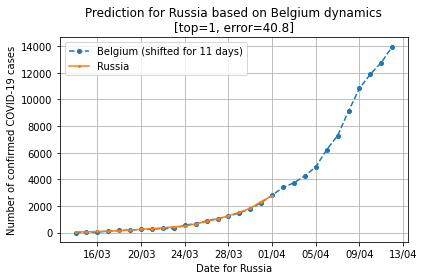

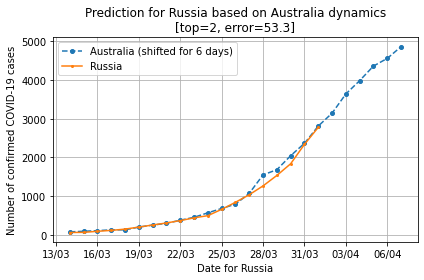

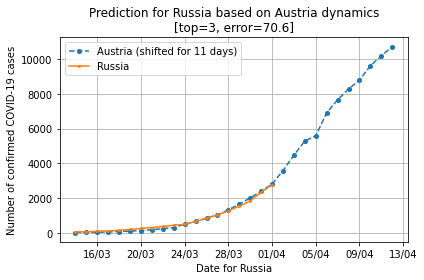

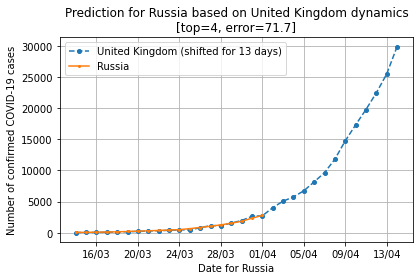

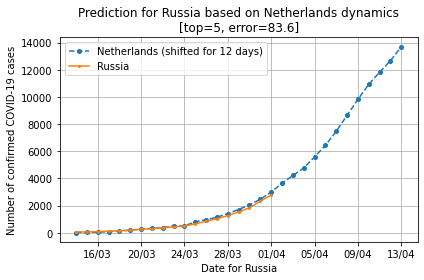

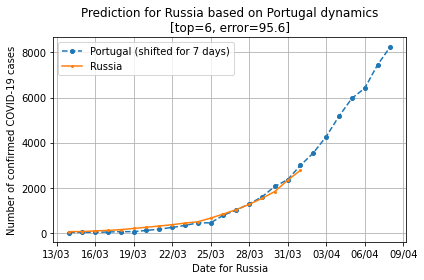

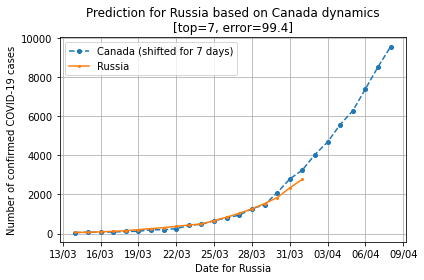

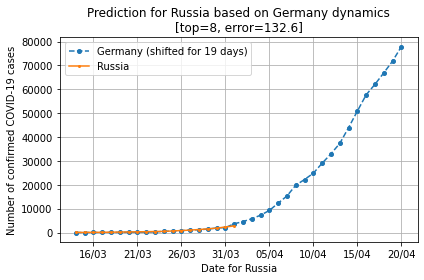

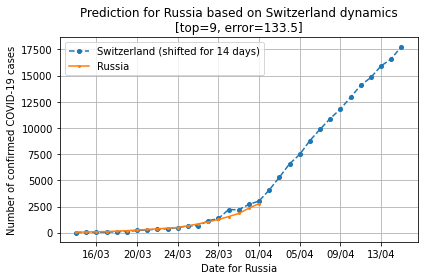

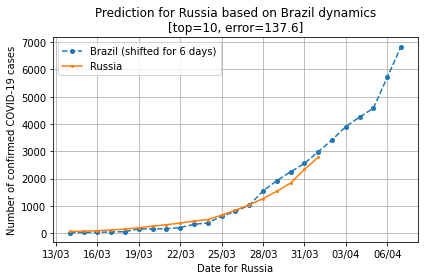

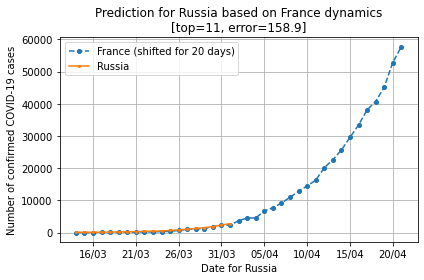

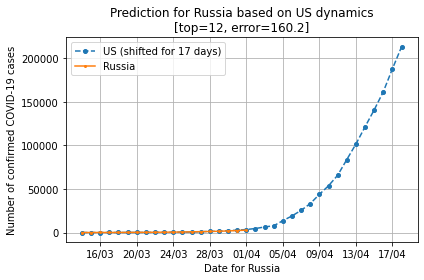

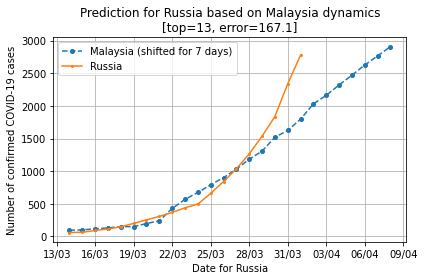

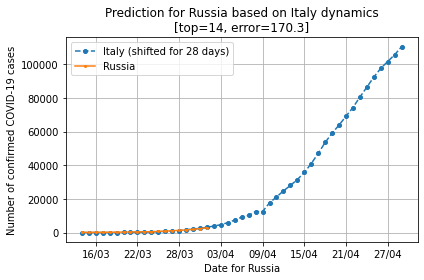

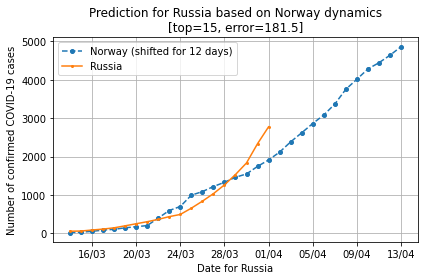

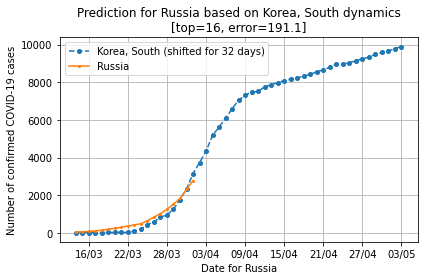

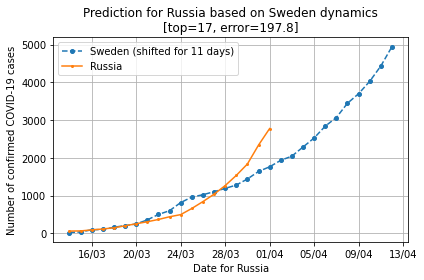

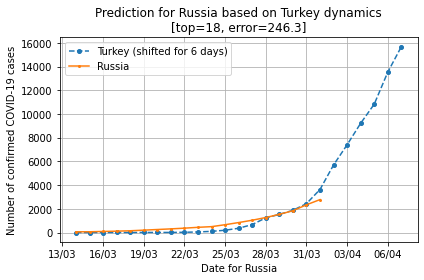

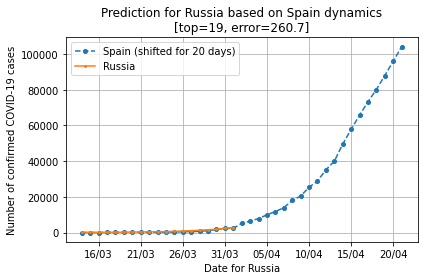

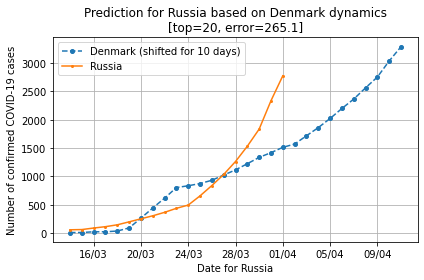

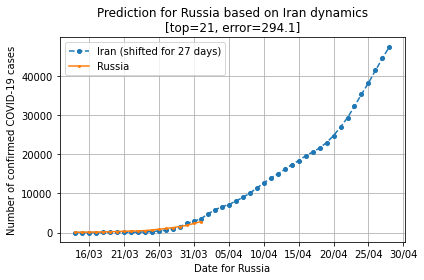

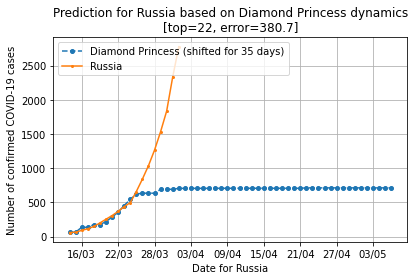

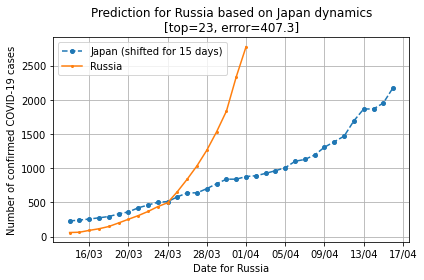

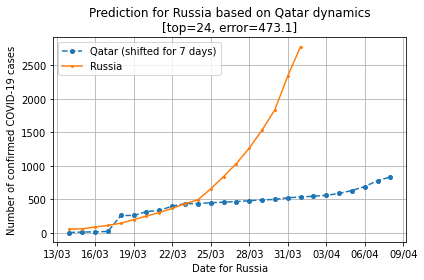

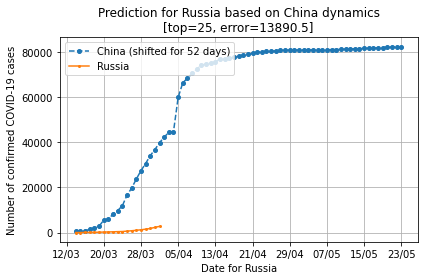

In [8]:
results_dir = os.path.join('results', base_location)
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir)

top = 1
for ref_location in keys_sorted:
    values = match_results[ref_location]
    if len(values['ref_confirmed'][values['min_error_index']:]) <= MIN_DELAY + len(values['base_confirmed']):
        continue
    
    # future
    fig, ax = plt.subplots()
    
    ax.set_title("Prediction for {} based on {} dynamics\n[top={}, error={:.1f}]".format(base_location, ref_location, top, values['error']))
    ax.set_xlabel("Date for {}".format(base_location))
    ax.set_ylabel("Number of confirmed COVID-19 cases".format(base_location))
    
    # shift and plot
    shift = values['base_dates'][0] - values['ref_dates'][values['min_error_index']]
    ref_dates = [shift + date for date in values['ref_dates'][values['min_error_index']:]]
    
    ax.plot(ref_dates, values['ref_confirmed'][values['min_error_index']:], linestyle='--', marker='o', ms=4, label="{} (shifted for {} days)".format(ref_location, shift.days))
    ax.plot(values['base_dates'], values['base_confirmed'], linestyle='-', marker='o', ms=2, label=base_location)
    
    # format dates
    days = mdates.DayLocator()
    days_fmt = mdates.DateFormatter('%d/%m')
    
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(days_fmt)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    ax.grid(True)
    ax.legend(loc='upper left')
    
    fig.tight_layout()
    
    # save result
    result_path = os.path.join(results_dir, "{:03}_{}.png".format(top, ref_location.replace(' ', '_')))
    fig.savefig(result_path, dpi=200)
    
    plt.show()
    
    top += 1